## Задача 1

Реализовать класс для работы с линейной регрессией

In [ ]:
import pandas as pd
import numpy as np

class MyLinearRegression:
    """
    Parameters
    ----------
    regularization : {None, 'l1', 'l2', 'l1l2'}, default=None
        Какую регуляризацию добавить к модели. Если значение `None`, то без регуляризации.

    weight_calc : {'matrix', 'gd', 'sgd'}, default='matrix'
        Каким образом вычислять вектор весов: матрично ('matrix'), градиентным спуском ('gd') или стохастическим градиентным спуском ('sgd'). При этом, при 'l1' или 'l1l2' нельзя использовать параметр 'matrix'.

    Attributes
    ----------
    coefs_ : Вектор коэффициентов размера (p, 1), где p — количество признаков.
    intercept_ : Значение коэффициента, отвечающего за смещение
    """

    def __init__(self, regularization=None, weight_calc='matrix', lambda_1=None, lambda_2=None, batch_size=20, lr=0.0005,
        n_iters=20000,
        random_state=42,):
        if regularization not in [None, 'l1', 'l2', 'l1l2']:
            raise TypeError(f"Параметр regularization не может принимать значение '{regularization}'")
        if weight_calc not in ['matrix', 'gd', 'sgd'] or (weight_calc == 'matrix' and regularization in ['l1', 'l1l2']):
            raise TypeError(f"Параметр weight_calc не может принимать значение '{weight_calc}'")
        if regularization in ['l1', 'l1l2'] and lambda_1 is None:
            raise TypeError(f"Значение коэффициента регулризации l1 не задано")
        if regularization in ['l2', 'l1l2'] and lambda_2 is None:
            raise TypeError(f"Значение коэффициента регулризации l2 не задано")

        self.weight_calc = weight_calc
        self.regularization = regularization
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.batch_size = batch_size

        # параметры для gd/sgd
        self.lr = lr
        self.n_iters = n_iters
        self.random_state = random_state

        # параметры после обучения
        self.coefs_ = None
        self.intercept_ = None

    @staticmethod
    def _to_numpy(X, y=None):
        if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
            Xn = X.to_numpy(dtype=float)
        else:
            Xn = np.array(X, dtype=float)

        if y is None:
            return Xn

        if isinstance(y, pd.DataFrame) or isinstance(y, pd.Series):
            yn = y.to_numpy(dtype=float).reshape(-1, 1)
        else:
            yn = np.array(y, dtype=float).reshape(-1, 1)
        return Xn, yn
    
    @staticmethod
    def _add_bias(X):
        # добавляем столбец единиц
        return np.hstack([np.ones((X.shape[0], 1)), X])
    

    def _regularization_grad(self, w):
        """
        Градиент регуляризации по w.
        """
        grad = np.zeros_like(w)

        if self.regularization in ["l2", "l1l2"]:
            # d/dw (lambda2/2 * ||w||^2) = lambda2 * w
            grad[1:] += self.lambda_2 * w[1:]

        if self.regularization in ["l1", "l1l2"]:
            # subgradient: d/dw (lambda1 * sum |w|) = lambda1 * sign(w)
            grad[1:] += self.lambda_1 * np.sign(w[1:])

        return grad
    

    def fit(self, X: pd.DataFrame, y: pd.DataFrame):
        Xn, yn = self._to_numpy(X, y)          # Xn: (n,p), yn: (n,1)
        n, p = Xn.shape

        if np.isnan(Xn).any() or np.isnan(yn).any():
            raise ValueError("В X или y есть NaN. Заполни пропуски до fit().")

        if self.weight_calc == "matrix":
            # w = (XᵀX)⁺ Xᵀy,  где X = [1, x_1, …, x_p]
            Xb = self._add_bias(Xn)            # (n, p+1)
            w = np.linalg.pinv(Xb.T @ Xb) @ (Xb.T @ yn)  # (p+1,1)

            self.intercept_ = float(w[0, 0])
            self.coefs_ = w[1:, :]
            return self

        #стандартизация x
        mu_x = Xn.mean(axis=0, keepdims=True)
        std_x = Xn.std(axis=0, keepdims=True)
        std_x = np.where(std_x < 1e-12, 1.0, std_x)  # чтобы не делить на 0

        Xs = (Xn - mu_x) / std_x     # (n,p)
        Xb = self._add_bias(Xs)      # (n,p+1)

        # стандартизация y
        mu_y = float(yn.mean())
        std_y = float(yn.std())
        if std_y < 1e-12:
            std_y = 1.0
        ys = (yn - mu_y) / std_y     # (n,1)

        # веса в стандартизированном пространстве (bias + p)
        w = np.zeros((p + 1, 1), dtype=float)

        # ---- 3) оптимизация ----
        rng = np.random.default_rng(getattr(self, "random_state", 42))
        lr = getattr(self, "lr", 1e-4)               
        n_iters = getattr(self, "n_iters", 20000)    
        batch_size = max(1, int(self.batch_size))

        def reg_grad(w_):
            # regularization gradient по w (bias не регуляризуем)
            g = np.zeros_like(w_)
            if self.regularization in ["l2", "l1l2"]:
                g[1:] += self.lambda_2 * w_[1:]
            if self.regularization in ["l1", "l1l2"]:
                g[1:] += self.lambda_1 * np.sign(w_[1:])
            return g

        for _ in range(n_iters):
            if self.weight_calc == "gd":
                Xcur = Xb
                ycur = ys
            else:  # sgd 
                idx = rng.choice(n, size=min(batch_size, n), replace=False)
                Xcur = Xb[idx]
                ycur = ys[idx]

            m = Xcur.shape[0]
            y_pred = Xcur @ w                       

            # grad MSE: (2/m) X^T (Xw - y)
            grad_mse = (2.0 / m) * (Xcur.T @ (y_pred - ycur))
            grad = grad_mse + reg_grad(w)


            w -= lr * grad

            if not np.isfinite(w).all():
                raise ValueError("Weights exploded to NaN/Inf. Уменьши lr или увеличь scaling/clip.")

        # ---- 4) переводим веса обратно в исходный масштаб ----
        # В стандартизированном виде:
        # y_s = w0 + sum_j wj * (xj - mu_j)/std_j
        # y = mu_y + std_y * y_s
        #
        # => coef_orig_j = std_y * wj / std_j
        # => intercept_orig = mu_y + std_y*w0 - sum_j (std_y*wj*mu_j/std_j)

        w0 = float(w[0, 0])
        w_lin = w[1:, 0].reshape(1, -1)              # (1,p)

        coef_orig = (std_y * (w_lin / std_x)).reshape(-1, 1)  # (p,1)
        intercept_orig = mu_y + std_y * w0 - float((std_y * (w_lin * (mu_x / std_x))).sum())

        self.intercept_ = float(intercept_orig)
        self.coefs_ = coef_orig

        return self

    def predict(self, X: np.array, ss=True):
        if self.coefs_ is None or self.intercept_ is None:
            raise ValueError("Модель не обучена: сначала вызовите fit().")

        Xn = self._to_numpy(X)
        y_pred = self.intercept_ + Xn @ self.coefs_  # (n,1)

        if ss: #same shape
            return y_pred
        return y_pred.ravel()

    def score(self, X: np.array, y: np.array):
        """
        R^2 = 1 - SSE/SST
        """
        Xn, yn = self._to_numpy(X, y)
        y_pred = self.predict(Xn, ss=True)

        sse = float(np.sum((yn - y_pred) ** 2))
        sst = float(np.sum((yn - np.mean(yn)) ** 2))
        if sst < 1e-12:
            return 0.0
        return 1.0 - sse / sst

Используя датасет про автомобили (целевой признак — price), сравнить (качество, скорость обучения и предсказания, важность признаков) модели `MyLinearRegression` с различными гиперпараметрами, сделать выводы. На этом же датасете сравнить модель `MyLinearRegression` с библиотечной реализацией из `sklearn`, составить таблицу(ы) (графики) результатов сравнения (качество, скорость обучения и предсказания, важность признаков).

## 1) Модель и обозначения

$$
X \in \mathbb{R}^{n\times p}, \quad y \in \mathbb{R}^{n}.
$$

Линейная регрессия:

$$
\hat{y} = b + Xw,
$$

где $$w \in \mathbb{R}^{p},\; b\in\mathbb{R}.$$

Добавим столбец единиц:

$$
X_b = \begin{pmatrix}\mathbf{1} & X\end{pmatrix}\in\mathbb{R}^{n\times(p+1)}, 
\quad 
\tilde{w}=\begin{pmatrix}b\\w\end{pmatrix}\in\mathbb{R}^{p+1}.
$$

Тогда:

$$
\hat{y} = X_b \tilde{w}.
$$

## 2) Функция потерь (MSE) и оптимизация

Используем среднеквадратичную ошибку:

$$
\mathcal{L}(\tilde{w}) = \frac{1}{n}\sum_{i=1}^{n}(y_i-\hat{y}_i)^2
= \frac{1}{n}\|y - X_b\tilde{w}\|_2^2.
$$

Задача обучения:

$$
\tilde{w}^\star = \arg\min_{\tilde{w}} \; \frac{1}{n}\|y - X_b\tilde{w}\|_2^2.
$$

## 3) Матричное решение (подробно)

### 3.1) Модель в матричном виде

Добавим столбец единиц к матрице признаков, чтобы учесть свободный член:

$$
X_b = \begin{pmatrix}\mathbf{1} & X\end{pmatrix}\in\mathbb{R}^{n\times(p+1)}, 
\qquad
\tilde{w}=\begin{pmatrix}b\\w\end{pmatrix}\in\mathbb{R}^{p+1}.
$$

Тогда предсказания всей выборки записываются компактно:

$$
\hat{y} = X_b\tilde{w}.
$$

---

### 3.2) Функция потерь (MSE)

Используем среднеквадратичную ошибку:

$$
\mathcal{L}(\tilde{w})
=\frac{1}{n}\|y - X_b\tilde{w}\|_2^2.
$$

Квадрат нормы можно раскрыть:

$$
\|y - X_b\tilde{w}\|_2^2
=(y - X_b\tilde{w})^T (y - X_b\tilde{w}).
$$

---

### 3.3) Раскрытие скобок

Раскроем выражение:

$$
(y - X_b\tilde{w})^T (y - X_b\tilde{w})
= y^Ty - 2\tilde{w}^T X_b^T y + \tilde{w}^T X_b^T X_b \tilde{w}.
$$

Тогда

$$
\mathcal{L}(\tilde{w})
=\frac{1}{n}\Big( y^Ty - 2\tilde{w}^T X_b^T y + \tilde{w}^T X_b^T X_b \tilde{w}\Big).
$$

---

### 3.4) Берём градиент по $\tilde{w}$

Используем стандартные факты матричного дифференцирования:

- $$\nabla_{\tilde{w}}(\tilde{w}^T A \tilde{w}) = (A + A^T)\tilde{w}$$
- если $$A=A^T$$ (симметричная), то $$\nabla_{\tilde{w}}(\tilde{w}^T A \tilde{w}) = 2A\tilde{w}$$
- $$\nabla_{\tilde{w}}(\tilde{w}^T c) = c$$

Здесь матрица $$X_b^T X_b$$ симметрична, поэтому:

$$
\nabla_{\tilde{w}} \mathcal{L}(\tilde{w})
=\frac{1}{n}\Big(-2X_b^T y + 2X_b^T X_b \tilde{w}\Big)
=\frac{2}{n}X_b^T(X_b\tilde{w}-y).
$$

---

### 3.5) Условие минимума: нормальные уравнения

В точке минимума градиент равен нулю:

$$
\nabla_{\tilde{w}} \mathcal{L}(\tilde{w}) = 0
\quad\Longrightarrow\quad
X_b^T(X_b\tilde{w}-y)=0.
$$

Переносим:

$$
X_b^T X_b \tilde{w} = X_b^T y.
$$

Это и есть **нормальные уравнения**.

---

### 3.6) Явное решение

Если матрица $$X_b^T X_b$$ обратима, то:

$$
\boxed{\tilde{w}=(X_b^T X_b)^{-1}X_b^T y}.
$$

---

<!-- ### 3.7) Почему используем псевдообратную (как в коде)

На практике $$X_b^T X_b$$ может быть:

- необратима (например, признаки линейно зависимы),
- плохо обусловлена (численно нестабильна).

Тогда вместо обычной обратной берут **псевдообратную матрицу**:

$$
\boxed{\tilde{w}=(X_b^T X_b)^{+}X_b^T y}.
$$

Это даёт устойчивое решение и работает даже при мультиколлинеарности.

---

### 3.8) Что именно получаем из $\tilde{w}$

После вычисления

$$
\tilde{w}=
\begin{pmatrix}
\tilde{w}_0\\
\tilde{w}_1\\
\vdots\\
\tilde{w}_p
\end{pmatrix},
$$

мы интерпретируем:

*$$b = \tilde{w}_0 $$ — (смещение),
*$$w = (\tilde{w}_1,\dots,\tilde{w}_p)^T $$ — коэффициенты при признаках. -->

## 4) Стандартизация признаков X (для GD/SGD)

Для каждого признака $$j=1,\dots,p$$ считаем:

$$
\mu_j=\frac{1}{n}\sum_{i=1}^{n}x_{ij},
\quad
\sigma_j=\sqrt{\frac{1}{n}\sum_{i=1}^{n}(x_{ij}-\mu_j)^2}.
$$

Стандартизация:

$$
x'_{ij}=\frac{x_{ij}-\mu_j}{\sigma_j}.
$$

В матричном виде:

$$
X_s = (X-\mu)\oslash\sigma.
$$

Далее добавляем bias:

$$
X_{sb}=\begin{pmatrix}\mathbf{1} & X_s\end{pmatrix}.
$$

Если $$\sigma_j \approx 0$$, то в коде берём $$\sigma_j=1$$, чтобы избежать деления на ноль.

## 5) Стандартизация целевой переменной y (в нашей fit для устойчивости)

Считаем:

$$
\mu_y=\frac{1}{n}\sum_{i=1}^{n}y_i,
\quad
\sigma_y=\sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i-\mu_y)^2}.
$$

Стандартизация цели:

$$
y_s=\frac{y-\mu_y}{\sigma_y}.
$$

Обучаем модель в стандартизированном пространстве (это уменьшает градиенты и предотвращает NaN).

## 6) Градиент MSE и обновление (GD)

В стандартизированном пространстве:

$$
\hat{y}_s = X_{sb}\tilde{w}_s.
$$

Функция потерь:

$$
\mathcal{L}(\tilde{w}_s)=\frac{1}{n}\|y_s - X_{sb}\tilde{w}_s\|_2^2.
$$

Градиент:

$$
\nabla \mathcal{L}(\tilde{w}_s)=\frac{2}{n}X_{sb}^T(X_{sb}\tilde{w}_s - y_s).
$$

Шаг GD:

$$
\boxed{\tilde{w}_s \leftarrow \tilde{w}_s - \eta \cdot \frac{2}{n}X_{sb}^T(X_{sb}\tilde{w}_s - y_s)}.
$$

## 7) SGD (mini-batch)

Берём мини-батч $$B$$ размера $$m$$ и считаем градиент по нему:

$$
\nabla \mathcal{L}_B(\tilde{w}_s)=\frac{2}{m}X_{sb,B}^T(X_{sb,B}\tilde{w}_s - y_{s,B}).
$$

Шаг SGD:

$$
\boxed{\tilde{w}_s \leftarrow \tilde{w}_s - \eta \cdot \frac{2}{m}X_{sb,B}^T(X_{sb,B}\tilde{w}_s - y_{s,B})}.
$$

## 8) Регуляризация (L2 / L1 / L1L2)

Bias (свободный член) обычно не регуляризуют.

### L2 (Ridge)

Штраф:

$$
\frac{\lambda_2}{2}\|w\|_2^2.
$$

Добавка к градиенту:

$$
+\lambda_2 w.
$$

### L1 (Lasso)

Штраф:

$$
\lambda_1\|w\|_1.
$$

Субградиент:

$$
+\lambda_1\operatorname{sign}(w).
$$

### L1+L2 (Elastic Net)

Полный градиент (в коде суммируется с MSE-градиентом):

$$
\nabla = \frac{2}{n}X_{sb}^T(X_{sb}\tilde{w}_s - y_s)
+ \lambda_2 w
+ \lambda_1\operatorname{sign}(w).
$$

## 9) Возврат коэффициентов в исходный масштаб

Модель обучена так:

$$
\hat{y}_s = w_0 + \sum_{j=1}^{p} w_j \frac{x_j-\mu_j}{\sigma_j}.
$$

Возвращаемся к исходной цели:

$$
\hat{y} = \mu_y + \sigma_y \hat{y}_s.
$$

Тогда коэффициенты в исходном масштабе:

$$
\boxed{w^{\text{orig}}_j = \sigma_y \frac{w_j}{\sigma_j}}.
$$

Свободный член:

$$
\boxed{b^{\text{orig}} = \mu_y + \sigma_y w_0 - \sum_{j=1}^{p}\sigma_y w_j\frac{\mu_j}{\sigma_j}}.
$$

In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge

DATA_PATH = "/Users/macbook/Documents/ML/Lab_4_Stat/Used_fiat_500_in_Italy_dataset.csv"
TARGET = "price"
TEST_SIZE = 0.2
RANDOM_STATE = 42

In [3]:
df = pd.read_csv(DATA_PATH)

y = df[TARGET].copy()
X = df.drop(columns=[TARGET]).copy()

# заполним пропуски 
for c in X.columns:
    if pd.api.types.is_numeric_dtype(X[c]):
        X[c] = X[c].fillna(X[c].median())
    else:
        X[c] = X[c].fillna("missing")

# one-hot для категорий
X = pd.get_dummies(X, drop_first=True)
feature_names = X.columns.tolist()
X = X.fillna(0.0)

In [4]:
print("NaN in X:", X.isna().sum().sum())
print("NaN in y:", y.isna().sum())

NaN in X: 0
NaN in y: 0


In [5]:
# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

In [6]:
def evaluate_my(model, X_train, y_train, X_test, y_test):
    y_train_df = pd.DataFrame(y_train.values)     # (n,1) для твоего fit
    y_test_np = y_test.values.reshape(-1, 1)

    t0 = time.perf_counter()
    model.fit(X_train, y_train_df)
    fit_time = time.perf_counter() - t0

    t0 = time.perf_counter()
    y_pred = model.predict(X_test, ss=False)  
      
    pred_time = time.perf_counter() - t0

    r2 = r2_score(y_test_np.ravel(), y_pred)
    mse = mean_squared_error(y_test_np.ravel(), y_pred)

    coefs = model.coefs_.ravel()
                     
    return fit_time, pred_time, r2, mse, coefs



def evaluate_sklearn(model, X_train, y_train, X_test, y_test):
    t0 = time.perf_counter()
    model.fit(X_train, y_train)
    fit_time = time.perf_counter() - t0

    t0 = time.perf_counter()
    y_pred = model.predict(X_test)
    pred_time = time.perf_counter() - t0

    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    coefs = model.coef_                           
    return fit_time, pred_time, r2, mse, coefs


def top10_features(coefs, feature_names):
    s = pd.Series(np.abs(coefs), index=feature_names).sort_values(ascending=False)
    return s.head(10)

In [7]:
results = []
coefs_dict = {}

# --- MyLinearRegression (несколько вариантов) ---
my_models = [
    ("MyLR_matrix", MyLinearRegression(weight_calc="matrix")),
    ("MyLR_gd_l2",   MyLinearRegression(weight_calc="gd", regularization="l2",
                                        lambda_2=0.01, lr=0.05, n_iters=3000)),
    ("MyLR_sgd_l2",  MyLinearRegression(weight_calc="sgd", regularization="l2",
                                        lambda_2=0.01, lr=0.05, n_iters=6000, batch_size=32)),
]

for name, model in my_models:
    fit_t, pred_t, r2, mse, coefs = evaluate_my(model, X_train, y_train, X_test, y_test)
    results.append([name, "MyLinearRegression", fit_t, pred_t, r2, mse])
    coefs_dict[name] = coefs


# --- sklearn модели ---
sk_models = [
    ("sklearn_LinearRegression", LinearRegression()),
    ("sklearn_Ridge(0.01)", Ridge(alpha=0.01, random_state=RANDOM_STATE)),
]

for name, model in sk_models:
    fit_t, pred_t, r2, mse, coefs = evaluate_sklearn(model, X_train, y_train, X_test, y_test)
    results.append([name, "sklearn", fit_t, pred_t, r2, mse])
    coefs_dict[name] = coefs


results_df = pd.DataFrame(
    results, columns=["model", "type", "fit_time", "pred_time", "R2", "MSE"]
).sort_values("R2", ascending=False)

print("\n=== Сравнение моделей (сортировка по R2) ===")
print(results_df.to_string(index=False))


=== Сравнение моделей (сортировка по R2) ===
                   model               type  fit_time  pred_time       R2           MSE
             MyLR_matrix MyLinearRegression  0.000980   0.000034 0.894534 538361.651220
sklearn_LinearRegression            sklearn  0.010925   0.000531 0.894534 538361.652863
     sklearn_Ridge(0.01)            sklearn  0.003211   0.000381 0.894533 538365.939565
             MyLR_sgd_l2 MyLinearRegression  0.088769   0.000039 0.894453 538775.145610
              MyLR_gd_l2 MyLinearRegression  0.030364   0.000059 0.894318 539460.984611



Лучшая модель по R2: MyLR_matrix

Top-10 важностей (|coef|):
model_star             623.489501
model_sport            145.108204
lon                    112.448578
model_pop              105.904454
lat                    105.873264
previous_owners         88.792588
transmission_manual     12.909742
engine_power             3.926494
age_in_days              1.102817
km                       0.011953
dtype: float64


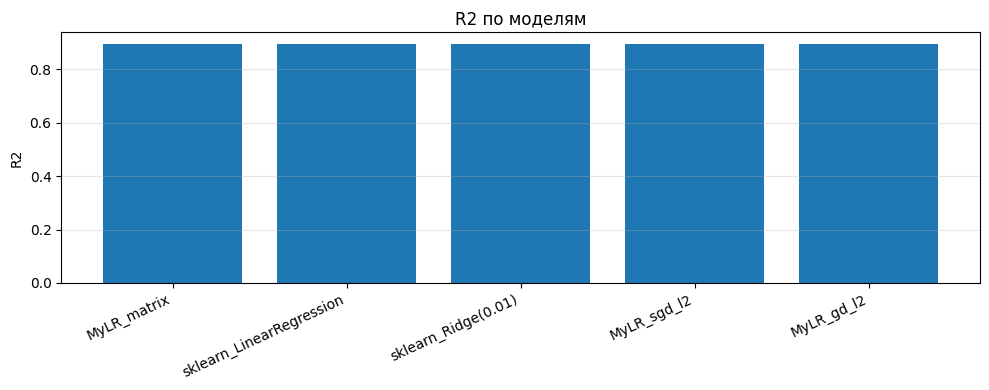

In [8]:
best_model = results_df.iloc[0]["model"]
print(f"\nЛучшая модель по R2: {best_model}")
print("\nTop-10 важностей (|coef|):")
print(top10_features(coefs_dict[best_model], feature_names))

# график R2
plt.figure(figsize=(10, 4))
plt.bar(results_df["model"], results_df["R2"])
plt.xticks(rotation=25, ha="right")
plt.ylabel("R2")
plt.title("R2 по моделям")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

## Задача 2

[Соревнование на Kaggle](https://kaggle.com/competitions/yadro-regression-2025)